In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.io import loadmat
from scipy.signal import spectrogram

In [3]:
eeg_mat = loadmat('OngoingEEG_data.mat')
eeg_mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Properties', 'EEGData', 'EEGPosition', 'EEGPoints', 'EEGChannelList', 'FileName', 'NodeName', 'Analyzer', 'fname', 'pname', 'samplingRate'])

In [4]:
eeg = eeg_mat['EEGData'].ravel()

fs = eeg_mat['samplingRate'].ravel()[0]
N = eeg.shape[0]
t = np.linspace(0, N / fs, N, endpoint=False)

In [5]:
t[-1] / 2

163.49951171875

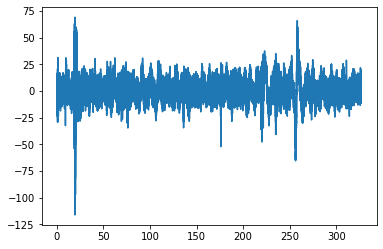

In [6]:
fig, ax = plt.subplots()
ax.plot(t, eeg)

(0.0, 20.0)

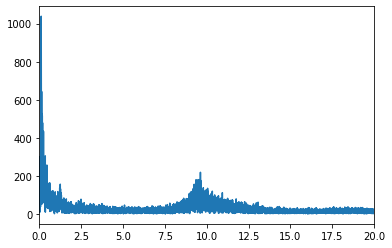

In [7]:
xf = fft(eeg)[:N // 2]
ff = fftfreq(N, 1 / fs)[:N // 2]

fig, ax = plt.subplots()
ax.plot(ff, 2 / fs * np.abs(xf))
ax.set_xlim([0, 20])

511.99694189602445


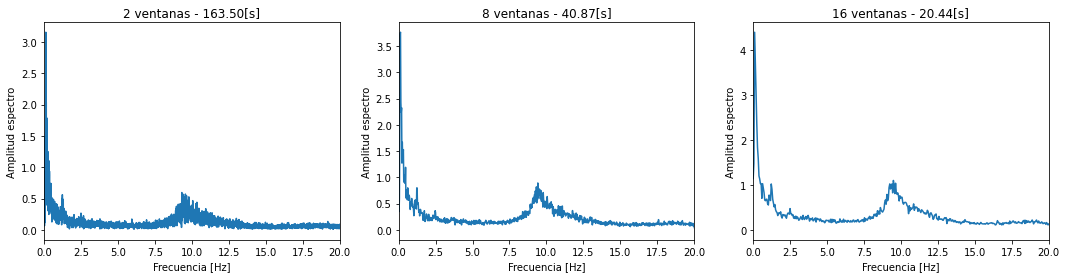

In [8]:
def win_fft(win_size):
    win_size = int(win_size)

    fft_arr = []
    ff = fftfreq(win_size, 1 / fs)[:win_size // 2]
    k = 0

    while k < t.shape[0]:
        xf = fft(eeg[k : k + win_size])[:win_size // 2]
        fft_arr.append(xf)

        k += win_size

    mxf = 2 / win_size * np.mean(np.abs(np.array(fft_arr)), axis=0)
    
    return ff, mxf

fig, ax = plt.subplots(1, 3, figsize=(18, 4))

fft0 = win_fft(N / 2)
fft1 = win_fft(N / 8)
fft2 = win_fft(N / 16)

ax[0].plot(fft0[0], fft0[1])
ax[1].plot(fft1[0], fft1[1])
ax[2].plot(fft2[0], fft2[1])

ax[0].set_xlim([0, 20])
ax[1].set_xlim([0, 20])
ax[2].set_xlim([0, 20])

ax[0].set_title('2 ventanas - {:.2f}[s]'.format(t[-1] / 2))
ax[1].set_title('8 ventanas - {:.2f}[s]'.format(t[-1] / 8))
ax[2].set_title('16 ventanas - {:.2f}[s]'.format(t[-1] / 16))

[_ax.set_xlabel('Frecuencia [Hz]') for _ax in ax]
[_ax.set_ylabel('Amplitud espectro') for _ax in ax]

fig.savefig('q1_test.png')
print(ff[-1])

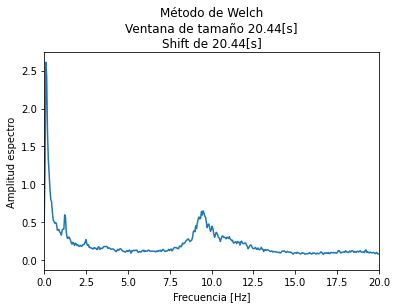

In [15]:
# Welch method
def welch(win_size):
    win_size = int(win_size)

    ff = fftfreq(win_size, 1 / fs)[:win_size // 2]
    k = 0
    
    mean_spec = np.zeros(int(win_size / 2))
    mean_signal = np.zeros(win_size)
    n_overlap = 0
    
    win = np.hanning(win_size)

    while k + win_size < t.shape[0] - 1:        
        xf = fft(win * eeg[k : k + win_size])[:win_size // 2]
#         fft_arr.append(xf)
        mean_spec += np.abs(xf)

        k += int(win_size / 2)
        n_overlap += 1
        
    mxf = 2 / win_size * mean_spec / n_overlap
    
    return ff, mxf

fig, ax = plt.subplots()

win_size = N / 16
w_spec = welch(win_size)

ax.plot(w_spec[0], w_spec[1])
ax.set_xlim([0, 20])

ax.set_title('Método de Welch\nVentana de tamaño {:.2f}[s]\nShift de {:.2f}[s]'.format(win_size / fs, win_size / fs))

ax.set_xlabel('Frecuencia [Hz]')
ax.set_ylabel('Amplitud espectro')
fig.savefig('welch_method.png')

In [63]:
# Slide FFT - overlap
def slide_win_fft(win_size, shift):
    win_size = int(win_size)

    fft_arr = []
    ff = fftfreq(win_size, 1 / fs)[:win_size // 2]
    k = 0
    
    wspec = np.zeros(int(win_size / 2))
    n_overlap = 0

    while k < t.shape[0] - win_size - 1:
        k_top = k + win_size if k + win_size < t.shape[0] else t.shape[0] - 1
        xf = fft(eeg[k : k_top])[:win_size // 2]
#         fft_arr.append(xf)
        wspec += np.abs(xf)

        k += shift
        n_overlap += 1
        
    print(n_overlap)

    mxf = 2 / win_size * wspec / n_overlap
    
    return ff, mxf

win_size = N / 16

fft0 = slide_win_fft(win_size, 1)
fft1 = slide_win_fft(win_size, 512)
fft2 = slide_win_fft(win_size, 4096)

313919
614
77


[Text(0, 0.5, 'Amplitud espectro'),
 Text(0, 0.5, 'Amplitud espectro'),
 Text(0, 0.5, 'Amplitud espectro')]

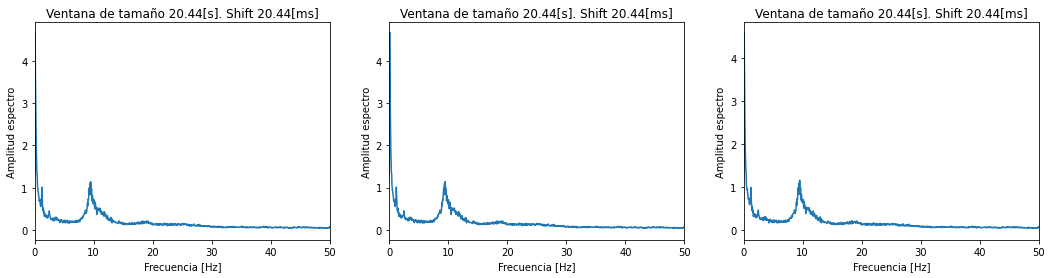

In [64]:
fig, ax = plt.subplots(1, 3, figsize=(18, 4))

ax[0].plot(fft0[0], fft0[1])
ax[1].plot(fft1[0], fft1[1])
ax[2].plot(fft2[0], fft2[1])

ax[0].set_xlim([0, 50])
ax[1].set_xlim([0, 50])
ax[2].set_xlim([0, 50])

ax[0].set_title('Ventana de tamaño {:.2f}[s]. Shift {:.2f}[ms]'.format(win_size / fs, win_size / fs))
ax[1].set_title('Ventana de tamaño {:.2f}[s]. Shift {:.2f}[ms]'.format(win_size / fs, win_size / fs))
ax[2].set_title('Ventana de tamaño {:.2f}[s]. Shift {:.2f}[ms]'.format(win_size / fs, win_size / fs))

[_ax.set_xlabel('Frecuencia [Hz]') for _ax in ax]
[_ax.set_ylabel('Amplitud espectro') for _ax in ax]

In [35]:
fs

1024